# Coarse Grained Monte Carlo (MC) Simulations For Osmotic Second Virial Coefficient Calculations

## Purpose

The purpose of this notebook is to perform Monte Carlo simulations at amino acid coarse grained level to calculate [osmotic second virial coefficient](https://en.wikipedia.org/wiki/Virial_expansion) of proteins for different salt conditions and pH values.


## Theory

Protein aggregation is a issue for biopharmaceutical industry and the ability to predict aggregation is crucial for the formulation of new protein-based drugs. Current prediction models account for conformational factor, defined as the difference in free energy between the folded and unfolded states and colloidal factor, defined as the balance of repulsive and attractive intermolecular interactions.

The osmotic second virial coefficient ($B_{2}$) is a measure of colloidal stability. It represents the first-order correction to the ideal gas law accounting for intermolecular interactions at two-body level, i.e., it describes dilute solutions where the interactions can be treated as pairwise additive.

\begin{equation}
\frac{p}{k_{b}T}= \rho + B_{2}(T)\rho^{2}+B_{2}\rho^{3} + ...
\end{equation}

It is defined as:

\begin{equation}
B_{2}=-2\pi \int_{0}^{\infty} (e^{lng(r)}-1)r_{12}^{2}dr_{12},
\end{equation}

where $g(r)$ is the radial distribution function, which gives the probability of finding a protein at a separation r 
from the other, compared to a ideal gas distribution.

## Model

The model consists of two proteins (in this case indentical) in a cylindrical space, modelled as a collection of particles, each representing one amino acid.
<img src="Model.png" alt="Drawing" style="width: 600px;"/>

The proteins are allowed to translate along z-axis and rotate around vectors going through their center of mass. The protonation states of each amino acid can also change according to the pH. Implicit salt and solvent are used.


## Before starting

In [66]:
### Import packages ###

%matplotlib inline
from IPython.display import IFrame
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import os.path, os
import json

### Define the work direrectory ###

try:
    workdir
except NameError:
    workdir=%pwd
else:
    %cd $workdir

/Users/michael/Desktop/project-work-MarcoPolimeni-master
/Users/michael/Desktop/project-work-MarcoPolimeni-master


## Visualize the protein

For the purpose of this notebook a small protein called plectasin will be used. Its structure can be visualized using a molecule viewer embedded in the code.

In [67]:
IFrame(src="http://molview.org/?pdbid=1ZFU", width=800, height=400)

## Load a pdb and coarse grain it at amino acid level

Before starting the MC simulations we need the coarse-grained structure. This part of the code loads a pdb from the Protein Data Bank https://www.rcsb.org/pdb/home/home.do and coarse grain it at amino acid level (each amino acid is replaced by a sphere) giving as output a file.aam that will be used for the simulations. 

In [68]:
%cd $workdir

traj=md.load_pdb('https://files.rcsb.org/view/1ZFU.pdb')  #Url for pdb structure                                 
                                               
for chain in traj.topology.chains:
    print('chain: ', chain.index)
    # filter pdb to only select protein(s)
    sel = chain.topology.select('protein')
    top = chain.topology.subset(sel)
    f = open('chain'+str(chain.index)+'.aam','w')
    f.write(str(top.n_residues)+'\n')
    
      
# loop over residues and calculate residue mass centers, radius, and weight 

for res in top.residues:
    if res.is_protein:
        cm = [0,0,0] # residue mass center
        mw = 0       # residue weight
        for a in res.atoms:
            cm = cm + a.element.mass * traj.xyz[0][a.index]
            mw = mw + a.element.mass
        cm = cm/mw*10
        radius = ( 3./(4*np.pi)*mw/1.0 )**(1/3.)
        f.write('{0:4} {1:5} {2:8.3f} {3:8.3f} {4:8.3f} {5:6.3f} {6:6.2f} {7:6.2f}\n'\
                .format(res.name,res.index,cm[0],cm[1],cm[2],0,mw,radius))
file = 'chain'+str(chain.index)+'.aam'
f.close()

/Users/michael/Desktop/project-work-MarcoPolimeni-master
chain:  0


//anaconda/lib/python3.5/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '



<img src="CG.png" width="800" />

## Download and compile Faunus

Faunus (https://github.com/mlund/faunusis) is a software for Monte Carlo simulations. In this part of the code we download and compile it. Then, the executable file (twobody) is copied into the work directory.


In [7]:
%%bash -s "$workdir"

if [ ! -d "faunus" ]; then  
  git clone https://github.com/mlund/faunus.git
  cd faunus
else
  cd faunus
fi 

cp ../twobody.cpp src/examples/ 

cmake . -DCMAKE_BUILD_TYPE=RelWithDebInfo 
make example_twobody -j4

cp src/examples/twobody ../
cd ..
chmod +x twobody

-- Could NOT find Doxygen (missing:  DOXYGEN_EXECUTABLE) 
-- Configuring done
-- Generating done
-- Build files have been written to: /Users/michael/Desktop/project-work-MarcoPolimeni-master/faunus
[ 28%] Built target docopt
[ 42%] Built target xdrfile
[ 85%] Built target libfaunus
Scanning dependencies of target example_twobody
[ 92%] Building CXX object src/examples/CMakeFiles/example_twobody.dir/twobody.cpp.o
[100%] Linking CXX executable twobody
[100%] Built target example_twobody


...............................................................
  Faunus is compiled in Debug mode to enable checks and
  assertions highly recommended when developing and testing.
  For production, switch to Release for optimal performance:

  -DCMAKE_BUILD_TYPE=Release
***************************************************************



## Input for Faunus

Model details as physical parameters, size of the simulation box, the number of step to be performed etc., can be changed in this part of the code. A json file containing all these parameters will be created.

In [69]:
%cd $workdir

###              ###
#SET OF PARAMETES#
###              ###

#Energy
epsr=78.7
mindist=0    # minimum allowed COM-COM distance (angstrom)
maxdist=200  # maximum allowed COM-COM distance (angstrom)    

#System
cylradius=55 # cylinder radius (angstrom)
cyllen=400   # cylinder length (angstrom)


#Moves
dp=15        # COM translational displacement parameter (angstrom)

#Moleculelist
offset=40    # initial COM-COM separation (angstrom)

#Analysis  
nstep_xtc=100  # frequency for saving frames to xtc trajectory file

#Atomlist
ljeps=0.12350 # LJ epsilon (kT)

#Number of simulation steps 
micro = 50000
macro = 100

#Function that determines the Debye Length corresponding to the salt concentration

def debye(conc):
    ''' Convert salt concentration (in M) to Debye lenght. 
        Valid at room temperature (25 °C) for 1:1 electrolytes.'''
    return 3.04/np.sqrt(conc)


#Function for input file
def mkinput():
    js = {
              "energy" : {
                  "___eqstate": { "processfile": "twobody.json" },
                  "nonbonded" : { "epsr" : 78.7, "coulombtype": "yukawa", "cutoff":2*D, "debyelength": D},
                  "cmconstrain" : {"0sphere 1sphere" : { "mindist": mindist, "maxdist": maxdist }}
                         },
                
               "system" : {
                  "temperature" : 298.15,
                  "geometry" : { "length" : cyllen, "radius" : cylradius },
                  "mcloop"   : { "macro" : macro, "micro" : micro }
                          },
                 
                "moves" : {
                  
                    #1
                    "titrate" : {
                      "prob":0.2,
                      "processes" : {
                            "H-Asp" : { "bound":"HASP" , "free":"ASP" , "pKd":4.0  , "pX":pH },
                            "H-Ctr" : { "bound":"HCTR" , "free":"CTR" , "pKd":2.6  , "pX":pH },
                            "H-Glu" : { "bound":"HGLU" , "free":"GLU" , "pKd":4.4  , "pX":pH },
                            "H-His" : { "bound":"HHIS" , "free":"HIS" , "pKd":6.3  , "pX":pH },
                            "H-Arg" : { "bound":"HARG" , "free":"ARG" , "pKd":12.0 , "pX":pH },
                            "H-Ntr" : { "bound":"HNTR" , "free":"NTR" , "pKd":7.5  , "pX":pH },
                            "H-Cys" : { "bound":"HCYS" , "free":"CYS" , "pKd":10.8 , "pX":pH },
                            "H-Tyr" : { "bound":"HTYR" , "free":"TYR" , "pKd":9.6  , "pX":pH },
                            "H-Lys" : { "bound":"HLYS" , "free":"LYS" , "pKd":10.4 , "pX":pH }
                                    }
                                },
                    #2
                    "moltransrot2body" : {
                    "0sphere" : { "dp":dp, "dprot":0.5 }, 
                    "1sphere" : { "dp":dp, "dprot":0.5 } 
                                         }
                         },
                
                "moleculelist": {
                  "0sphere":  { "structure":xyzfile, "Ninit":1, "insdir":"0 0 0", "insoffset":"0 0 "+str(offset)},
                  "1sphere":  { "structure":xyzfile, "Ninit":1, "insdir":"0 0 0", "insoffset":"0 0 -"+str(offset)}
                                },
        
                 "analysis" : {
                   "pqrfile" : { "file": "confout.pqr"  }, 
                   "chargemultipole": {"mollist" : ["0sphere","1sphere"], "nstep":10 },
                   "molrdf" : { "nstep":1, "pairs" : 
                            [ { "name1":"0sphere", "name2":"1sphere", "file":"rdf.dat", "dr":0.1, "dim":1 }]
                              },
                   "xtcfile" : { "file": "traj.xtc", "nstep": nstep_xtc },

                              },
            
                 "atomlist" : {
                    "ASP":  dict(q=-1, sigma=5.94, eps=ljeps, mw=110.05),
                    "HASP": dict(q=0,  sigma=5.94, eps=ljeps, mw=110.05),

                    "GLU":  dict(q=-1, sigma=6.16, eps=ljeps, mw=122.06),
                    "HGLU": dict(q=0,  sigma=6.16, eps=ljeps, mw=122.06),
                    
                    "HIS":  dict(q=0,  sigma=6.28, eps=ljeps, mw=130.08),
                    "HHIS": dict(q=1,  sigma=6.28, eps=ljeps, mw=130.08),
                    
                    "ARG":  dict(q=0,  sigma=6.66, eps=ljeps, mw=155.18),
                    "HARG": dict(q=1,  sigma=6.66, eps=ljeps, mw=155.18),
                     
                    "BCYS": dict(q=0, sigma=5.72, eps=ljeps, mw=98.10),
                    "CYS":  dict(q=-1, sigma=5.72, eps=ljeps, mw=98.10),
                    "HCYS": dict(q=0,  sigma=5.72, eps=ljeps, mw=98.10),
                    
                    "TYR":  dict(q=-1, sigma=6.66, eps=ljeps, mw=154.10),
                    "HTYR": dict(q=0,  sigma=6.66, eps=ljeps, mw=154.10),
                    
                    "LYS":  dict(q=0,  sigma=6.06, eps=ljeps, mw=116.08),
                    "HLYS": dict(q=1,  sigma=6.06, eps=ljeps, mw=116.08),
                    
                    "NTR": dict(q=0,  sigma=4.70, eps=ljeps, mw=54.03), #gly was N terminal
                    "HNTR": dict(q=1,  sigma=4.70, eps=ljeps, mw=54.03),
                    
                    "CTR": dict(q=-1,  sigma=4.70, eps=ljeps, mw=16.00), #TYR (tritable) is C terminal
                    "HCTR.": dict(q=0,  sigma=4.70, eps=ljeps, mw=16.00),
                     
                    "MET":  dict(q=0,  sigma=3.8, eps=ljeps,  mw=122),
                     
                    "GLN":  dict(q=0,  sigma=3.8, eps=ljeps,  mw=120),

                    "ASN":  dict(q=0,  sigma=5.58, eps=ljeps, mw=112.09),
                     
                    "GLY":  dict(q=0,  sigma=4.70, eps=ljeps, mw=54.03),

                    "PHE":  dict(q=0,  sigma=6.42, eps=ljeps, mw=138.10),

                    "PRO":  dict(q=0,  sigma=5.56, eps=ljeps, mw=90.06),

                    "TRP":  dict(q=0,  sigma=6.96, eps=ljeps, mw=176.13),

                    "LEU":  dict(q=0,  sigma=5.58, eps=ljeps, mw=111.14), 
                    
                    "SER":  dict(q=0,  sigma=5.40, eps=ljeps, mw=82.04),

                    "ILE":  dict(q=0,  sigma=5.80, eps=ljeps, mw=102.07),

                    "ALA":  dict(q=0,  sigma=5.02, eps=ljeps, mw=66.04),

                    "VAL":  dict(q=0,  sigma=5.56, eps=ljeps, mw=90.06),   
                }
        
    }


    json_str = json.dumps(js)


    with open('twobody.json', 'w') as f:
        json.dump(js, f, indent=4)

/Users/michael/Desktop/project-work-MarcoPolimeni-master


## Running the simulation

Note: with the selected number of micro/macro step the simulation will take around 10 minutes.

In [70]:
#Dictionary of proteins

proteins = {
    'Plectasin': {
        'xyzfile':'../../../chain0.aam',
        'conc': [0.02,0.06], 'pH': [3,4,5,6]
               }
           }

In [71]:
#Loop to run simulation for different salt conditions and pHs

for name, prop in proteins.items():
    xyzfile = prop['xyzfile']
    if not os.path.isdir(name):
        %mkdir -p $name 
        %cd $name
    else:    
        %cd $name    
    
    for csalt in prop ['conc']:
        if not os.path.isdir(str(csalt)):
            %mkdir -p $csalt
            %cd $csalt
        else:    
            %cd $csalt    
        
        for pH in prop['pH']:
            if not os.path.isdir(str(pH)):
                %mkdir -p $pH 
                %cd $pH
            else:    
                %cd $pH    
            D =debye(csalt)
            !rm -f state
            mkinput()
            ! ../../../twobody 
            %cd -q ../
        %cd -q ../  


/Users/michael/Desktop/project-work-MarcoPolimeni-master/Plectasin
/Users/michael/Desktop/project-work-MarcoPolimeni-master/Plectasin/0.02
/Users/michael/Desktop/project-work-MarcoPolimeni-master/Plectasin/0.02/3
Writing space state file 'init'. OK!
Reading space state file 'state'. State file not found.
# Reading process H-Arg ... OK!
# Reading process H-Asp ... OK!
# Reading process H-Ctr ... ignored.
# Reading process H-Cys ... OK!
# Reading process H-Glu ... OK!
# Reading process H-His ... OK!
# Reading process H-Lys ... OK!
# Reading process H-Ntr ... OK!
# Reading process H-Tyr ... OK!

 .................
  Atom Properties  
 *****************
  Number of entries:       32
  Element info:
    unk   ALA   ARG   ASN   ASP   BCYS  CTR   CYS   GLN   GLU   
    GLY   HARG  HASP  HCTR. HCYS  HGLU  HHIS  HIS   HLYS  HNTR  
    HTYR  ILE   LEU   LYS   MET   NTR   PHE   PRO   SER   TRP   
    TYR   VAL   

 ...............................
  Simulation Space and Geometry  
 ***************

  Steps:    1 / 50000       Macrosteps/min: 37      ETA: Mon Jan 29 12:26:47 2018
  Steps:    2 / 100000      Macrosteps/min: 38      ETA: Mon Jan 29 12:26:42 2018
  Steps:    3 / 150000      Macrosteps/min: 39      ETA: Mon Jan 29 12:26:42 2018
  Steps:    4 / 200000      Macrosteps/min: 38      ETA: Mon Jan 29 12:26:44 2018
  Steps:    5 / 250000      Macrosteps/min: 38      ETA: Mon Jan 29 12:26:44 2018
  Steps:    6 / 300000      Macrosteps/min: 38      ETA: Mon Jan 29 12:26:45 2018
  Steps:    7 / 350000      Macrosteps/min: 38      ETA: Mon Jan 29 12:26:44 2018
  Steps:    8 / 400000      Macrosteps/min: 38      ETA: Mon Jan 29 12:26:45 2018
  Steps:    9 / 450000      Macrosteps/min: 38      ETA: Mon Jan 29 12:26:44 2018
  Steps:   10 / 500000      Macrosteps/min: 38      ETA: Mon Jan 29 12:26:45 2018
  Steps:   11 / 550000      Macrosteps/min: 38      ETA: Mon Jan 29 12:26:46 2018
  Steps:   12 / 600000      Macrosteps/min: 38      ETA: Mon Jan 29 12:26:45 2018
  Steps:   13 / 

/Users/michael/Desktop/project-work-MarcoPolimeni-master/Plectasin/0.02/4
Writing space state file 'init'. OK!
Reading space state file 'state'. State file not found.
# Reading process H-Arg ... OK!
# Reading process H-Asp ... OK!
# Reading process H-Ctr ... ignored.
# Reading process H-Cys ... OK!
# Reading process H-Glu ... OK!
# Reading process H-His ... OK!
# Reading process H-Lys ... OK!
# Reading process H-Ntr ... OK!
# Reading process H-Tyr ... OK!

 .................
  Atom Properties  
 *****************
  Number of entries:       32
  Element info:
    unk   ALA   ARG   ASN   ASP   BCYS  CTR   CYS   GLN   GLU   
    GLY   HARG  HASP  HCTR. HCYS  HGLU  HHIS  HIS   HLYS  HNTR  
    HTYR  ILE   LEU   LYS   MET   NTR   PHE   PRO   SER   TRP   
    TYR   VAL   

 ...............................
  Simulation Space and Geometry  
 *******************************
  Boundary                 Cylinder (hard ends)
  Volume                   3.80133e+06 Å³ = 3801.33 nm³ = 3.80133e-21 lite

  Steps:    1 / 50000       Macrosteps/min: 36      ETA: Mon Jan 29 12:29:28 2018
  Steps:    2 / 100000      Macrosteps/min: 37      ETA: Mon Jan 29 12:29:25 2018
  Steps:    3 / 150000      Macrosteps/min: 37      ETA: Mon Jan 29 12:29:24 2018
  Steps:    4 / 200000      Macrosteps/min: 37      ETA: Mon Jan 29 12:29:24 2018
  Steps:    5 / 250000      Macrosteps/min: 37      ETA: Mon Jan 29 12:29:26 2018
  Steps:    6 / 300000      Macrosteps/min: 37      ETA: Mon Jan 29 12:29:25 2018
  Steps:    7 / 350000      Macrosteps/min: 37      ETA: Mon Jan 29 12:29:25 2018
  Steps:    8 / 400000      Macrosteps/min: 37      ETA: Mon Jan 29 12:29:24 2018
  Steps:    9 / 450000      Macrosteps/min: 38      ETA: Mon Jan 29 12:29:24 2018
  Steps:   10 / 500000      Macrosteps/min: 37      ETA: Mon Jan 29 12:29:25 2018
  Steps:   11 / 550000      Macrosteps/min: 38      ETA: Mon Jan 29 12:29:24 2018
  Steps:   12 / 600000      Macrosteps/min: 37      ETA: Mon Jan 29 12:29:25 2018
  Steps:   13 / 

/Users/michael/Desktop/project-work-MarcoPolimeni-master/Plectasin/0.02/5
Writing space state file 'init'. OK!
Reading space state file 'state'. State file not found.
# Reading process H-Arg ... OK!
# Reading process H-Asp ... OK!
# Reading process H-Ctr ... ignored.
# Reading process H-Cys ... OK!
# Reading process H-Glu ... OK!
# Reading process H-His ... OK!
# Reading process H-Lys ... OK!
# Reading process H-Ntr ... OK!
# Reading process H-Tyr ... OK!

 .................
  Atom Properties  
 *****************
  Number of entries:       32
  Element info:
    unk   ALA   ARG   ASN   ASP   BCYS  CTR   CYS   GLN   GLU   
    GLY   HARG  HASP  HCTR. HCYS  HGLU  HHIS  HIS   HLYS  HNTR  
    HTYR  ILE   LEU   LYS   MET   NTR   PHE   PRO   SER   TRP   
    TYR   VAL   

 ...............................
  Simulation Space and Geometry  
 *******************************
  Boundary                 Cylinder (hard ends)
  Volume                   3.80133e+06 Å³ = 3801.33 nm³ = 3.80133e-21 lite

  Steps:    1 / 50000       Macrosteps/min: 37      ETA: Mon Jan 29 12:32:08 2018
  Steps:    2 / 100000      Macrosteps/min: 37      ETA: Mon Jan 29 12:32:05 2018
  Steps:    3 / 150000      Macrosteps/min: 37      ETA: Mon Jan 29 12:32:10 2018
  Steps:    4 / 200000      Macrosteps/min: 36      ETA: Mon Jan 29 12:32:11 2018
  Steps:    5 / 250000      Macrosteps/min: 36      ETA: Mon Jan 29 12:32:12 2018
  Steps:    6 / 300000      Macrosteps/min: 36      ETA: Mon Jan 29 12:32:13 2018
  Steps:    7 / 350000      Macrosteps/min: 35      ETA: Mon Jan 29 12:32:15 2018
  Steps:    8 / 400000      Macrosteps/min: 35      ETA: Mon Jan 29 12:32:15 2018
  Steps:    9 / 450000      Macrosteps/min: 35      ETA: Mon Jan 29 12:32:15 2018
  Steps:   10 / 500000      Macrosteps/min: 35      ETA: Mon Jan 29 12:32:16 2018
  Steps:   11 / 550000      Macrosteps/min: 35      ETA: Mon Jan 29 12:32:16 2018
  Steps:   12 / 600000      Macrosteps/min: 35      ETA: Mon Jan 29 12:32:16 2018
  Steps:   13 / 

/Users/michael/Desktop/project-work-MarcoPolimeni-master/Plectasin/0.02/6
Writing space state file 'init'. OK!
Reading space state file 'state'. State file not found.
# Reading process H-Arg ... OK!
# Reading process H-Asp ... OK!
# Reading process H-Ctr ... ignored.
# Reading process H-Cys ... OK!
# Reading process H-Glu ... OK!
# Reading process H-His ... OK!
# Reading process H-Lys ... OK!
# Reading process H-Ntr ... OK!
# Reading process H-Tyr ... OK!

 .................
  Atom Properties  
 *****************
  Number of entries:       32
  Element info:
    unk   ALA   ARG   ASN   ASP   BCYS  CTR   CYS   GLN   GLU   
    GLY   HARG  HASP  HCTR. HCYS  HGLU  HHIS  HIS   HLYS  HNTR  
    HTYR  ILE   LEU   LYS   MET   NTR   PHE   PRO   SER   TRP   
    TYR   VAL   

 ...............................
  Simulation Space and Geometry  
 *******************************
  Boundary                 Cylinder (hard ends)
  Volume                   3.80133e+06 Å³ = 3801.33 nm³ = 3.80133e-21 lite

  Steps:    1 / 50000       Macrosteps/min: 38      ETA: Mon Jan 29 12:34:55 2018
  Steps:    2 / 100000      Macrosteps/min: 38      ETA: Mon Jan 29 12:34:51 2018
  Steps:    3 / 150000      Macrosteps/min: 37      ETA: Mon Jan 29 12:34:56 2018
  Steps:    4 / 200000      Macrosteps/min: 36      ETA: Mon Jan 29 12:35:00 2018
  Steps:    5 / 250000      Macrosteps/min: 36      ETA: Mon Jan 29 12:35:02 2018
  Steps:    6 / 300000      Macrosteps/min: 36      ETA: Mon Jan 29 12:35:02 2018
  Steps:    7 / 350000      Macrosteps/min: 36      ETA: Mon Jan 29 12:35:02 2018
  Steps:    8 / 400000      Macrosteps/min: 36      ETA: Mon Jan 29 12:35:01 2018
  Steps:    9 / 450000      Macrosteps/min: 36      ETA: Mon Jan 29 12:35:01 2018
  Steps:   10 / 500000      Macrosteps/min: 36      ETA: Mon Jan 29 12:35:01 2018
  Steps:   11 / 550000      Macrosteps/min: 36      ETA: Mon Jan 29 12:35:00 2018
  Steps:   12 / 600000      Macrosteps/min: 36      ETA: Mon Jan 29 12:35:00 2018
  Steps:   13 / 

/Users/michael/Desktop/project-work-MarcoPolimeni-master/Plectasin/0.06
/Users/michael/Desktop/project-work-MarcoPolimeni-master/Plectasin/0.06/3
Writing space state file 'init'. OK!
Reading space state file 'state'. State file not found.
# Reading process H-Arg ... OK!
# Reading process H-Asp ... OK!
# Reading process H-Ctr ... ignored.
# Reading process H-Cys ... OK!
# Reading process H-Glu ... OK!
# Reading process H-His ... OK!
# Reading process H-Lys ... OK!
# Reading process H-Ntr ... OK!
# Reading process H-Tyr ... OK!

 .................
  Atom Properties  
 *****************
  Number of entries:       32
  Element info:
    unk   ALA   ARG   ASN   ASP   BCYS  CTR   CYS   GLN   GLU   
    GLY   HARG  HASP  HCTR. HCYS  HGLU  HHIS  HIS   HLYS  HNTR  
    HTYR  ILE   LEU   LYS   MET   NTR   PHE   PRO   SER   TRP   
    TYR   VAL   

 ...............................
  Simulation Space and Geometry  
 *******************************
  Boundary                 Cylinder (hard ends)
  

  Steps:    1 / 50000       Macrosteps/min: 45      ETA: Mon Jan 29 12:37:05 2018
  Steps:    2 / 100000      Macrosteps/min: 46      ETA: Mon Jan 29 12:37:03 2018
  Steps:    3 / 150000      Macrosteps/min: 46      ETA: Mon Jan 29 12:37:02 2018
  Steps:    4 / 200000      Macrosteps/min: 46      ETA: Mon Jan 29 12:37:02 2018
  Steps:    5 / 250000      Macrosteps/min: 46      ETA: Mon Jan 29 12:37:03 2018
  Steps:    6 / 300000      Macrosteps/min: 45      ETA: Mon Jan 29 12:37:03 2018
  Steps:    7 / 350000      Macrosteps/min: 45      ETA: Mon Jan 29 12:37:03 2018
  Steps:    8 / 400000      Macrosteps/min: 46      ETA: Mon Jan 29 12:37:03 2018
  Steps:    9 / 450000      Macrosteps/min: 46      ETA: Mon Jan 29 12:37:03 2018
  Steps:   10 / 500000      Macrosteps/min: 46      ETA: Mon Jan 29 12:37:03 2018
  Steps:   11 / 550000      Macrosteps/min: 46      ETA: Mon Jan 29 12:37:02 2018
  Steps:   12 / 600000      Macrosteps/min: 46      ETA: Mon Jan 29 12:37:02 2018
  Steps:   13 / 

/Users/michael/Desktop/project-work-MarcoPolimeni-master/Plectasin/0.06/4
Writing space state file 'init'. OK!
Reading space state file 'state'. State file not found.
# Reading process H-Arg ... OK!
# Reading process H-Asp ... OK!
# Reading process H-Ctr ... ignored.
# Reading process H-Cys ... OK!
# Reading process H-Glu ... OK!
# Reading process H-His ... OK!
# Reading process H-Lys ... OK!
# Reading process H-Ntr ... OK!
# Reading process H-Tyr ... OK!

 .................
  Atom Properties  
 *****************
  Number of entries:       32
  Element info:
    unk   ALA   ARG   ASN   ASP   BCYS  CTR   CYS   GLN   GLU   
    GLY   HARG  HASP  HCTR. HCYS  HGLU  HHIS  HIS   HLYS  HNTR  
    HTYR  ILE   LEU   LYS   MET   NTR   PHE   PRO   SER   TRP   
    TYR   VAL   

 ...............................
  Simulation Space and Geometry  
 *******************************
  Boundary                 Cylinder (hard ends)
  Volume                   3.80133e+06 Å³ = 3801.33 nm³ = 3.80133e-21 lite

  Steps:    1 / 50000       Macrosteps/min: 45      ETA: Mon Jan 29 12:39:15 2018
  Steps:    2 / 100000      Macrosteps/min: 45      ETA: Mon Jan 29 12:39:15 2018
  Steps:    3 / 150000      Macrosteps/min: 45      ETA: Mon Jan 29 12:39:14 2018
  Steps:    4 / 200000      Macrosteps/min: 45      ETA: Mon Jan 29 12:39:14 2018
  Steps:    5 / 250000      Macrosteps/min: 45      ETA: Mon Jan 29 12:39:15 2018
  Steps:    6 / 300000      Macrosteps/min: 45      ETA: Mon Jan 29 12:39:15 2018
  Steps:    7 / 350000      Macrosteps/min: 45      ETA: Mon Jan 29 12:39:14 2018
  Steps:    8 / 400000      Macrosteps/min: 45      ETA: Mon Jan 29 12:39:15 2018
  Steps:    9 / 450000      Macrosteps/min: 45      ETA: Mon Jan 29 12:39:15 2018
  Steps:   10 / 500000      Macrosteps/min: 45      ETA: Mon Jan 29 12:39:14 2018
  Steps:   11 / 550000      Macrosteps/min: 45      ETA: Mon Jan 29 12:39:15 2018
  Steps:   12 / 600000      Macrosteps/min: 45      ETA: Mon Jan 29 12:39:15 2018
  Steps:   13 / 

/Users/michael/Desktop/project-work-MarcoPolimeni-master/Plectasin/0.06/5
Writing space state file 'init'. OK!
Reading space state file 'state'. State file not found.
# Reading process H-Arg ... OK!
# Reading process H-Asp ... OK!
# Reading process H-Ctr ... ignored.
# Reading process H-Cys ... OK!
# Reading process H-Glu ... OK!
# Reading process H-His ... OK!
# Reading process H-Lys ... OK!
# Reading process H-Ntr ... OK!
# Reading process H-Tyr ... OK!

 .................
  Atom Properties  
 *****************
  Number of entries:       32
  Element info:
    unk   ALA   ARG   ASN   ASP   BCYS  CTR   CYS   GLN   GLU   
    GLY   HARG  HASP  HCTR. HCYS  HGLU  HHIS  HIS   HLYS  HNTR  
    HTYR  ILE   LEU   LYS   MET   NTR   PHE   PRO   SER   TRP   
    TYR   VAL   

 ...............................
  Simulation Space and Geometry  
 *******************************
  Boundary                 Cylinder (hard ends)
  Volume                   3.80133e+06 Å³ = 3801.33 nm³ = 3.80133e-21 lite

  Steps:    1 / 50000       Macrosteps/min: 44      ETA: Mon Jan 29 12:41:33 2018
  Steps:    2 / 100000      Macrosteps/min: 44      ETA: Mon Jan 29 12:41:33 2018
  Steps:    3 / 150000      Macrosteps/min: 43      ETA: Mon Jan 29 12:41:34 2018
  Steps:    4 / 200000      Macrosteps/min: 43      ETA: Mon Jan 29 12:41:35 2018
  Steps:    5 / 250000      Macrosteps/min: 43      ETA: Mon Jan 29 12:41:35 2018
  Steps:    6 / 300000      Macrosteps/min: 43      ETA: Mon Jan 29 12:41:35 2018
  Steps:    7 / 350000      Macrosteps/min: 43      ETA: Mon Jan 29 12:41:35 2018
  Steps:    8 / 400000      Macrosteps/min: 43      ETA: Mon Jan 29 12:41:34 2018
  Steps:    9 / 450000      Macrosteps/min: 43      ETA: Mon Jan 29 12:41:34 2018
  Steps:   10 / 500000      Macrosteps/min: 43      ETA: Mon Jan 29 12:41:35 2018
  Steps:   11 / 550000      Macrosteps/min: 43      ETA: Mon Jan 29 12:41:34 2018
  Steps:   12 / 600000      Macrosteps/min: 43      ETA: Mon Jan 29 12:41:34 2018
  Steps:   13 / 

/Users/michael/Desktop/project-work-MarcoPolimeni-master/Plectasin/0.06/6
Writing space state file 'init'. OK!
Reading space state file 'state'. State file not found.
# Reading process H-Arg ... OK!
# Reading process H-Asp ... OK!
# Reading process H-Ctr ... ignored.
# Reading process H-Cys ... OK!
# Reading process H-Glu ... OK!
# Reading process H-His ... OK!
# Reading process H-Lys ... OK!
# Reading process H-Ntr ... OK!
# Reading process H-Tyr ... OK!

 .................
  Atom Properties  
 *****************
  Number of entries:       32
  Element info:
    unk   ALA   ARG   ASN   ASP   BCYS  CTR   CYS   GLN   GLU   
    GLY   HARG  HASP  HCTR. HCYS  HGLU  HHIS  HIS   HLYS  HNTR  
    HTYR  ILE   LEU   LYS   MET   NTR   PHE   PRO   SER   TRP   
    TYR   VAL   

 ...............................
  Simulation Space and Geometry  
 *******************************
  Boundary                 Cylinder (hard ends)
  Volume                   3.80133e+06 Å³ = 3801.33 nm³ = 3.80133e-21 lite

  Steps:    1 / 50000       Macrosteps/min: 45      ETA: Mon Jan 29 12:44:44 2018
  Steps:    2 / 100000      Macrosteps/min: 45      ETA: Mon Jan 29 12:44:43 2018
  Steps:    3 / 150000      Macrosteps/min: 45      ETA: Mon Jan 29 12:44:45 2018
  Steps:    4 / 200000      Macrosteps/min: 44      ETA: Mon Jan 29 12:44:46 2018
  Steps:    5 / 250000      Macrosteps/min: 44      ETA: Mon Jan 29 12:44:46 2018
  Steps:    6 / 300000      Macrosteps/min: 44      ETA: Mon Jan 29 12:44:46 2018
  Steps:    7 / 350000      Macrosteps/min: 44      ETA: Mon Jan 29 12:44:46 2018
  Steps:    8 / 400000      Macrosteps/min: 40      ETA: Mon Jan 29 12:45:23 2018
  Steps:    9 / 450000      Macrosteps/min: 40      ETA: Mon Jan 29 12:45:21 2018
  Steps:   10 / 500000      Macrosteps/min: 35      ETA: Mon Jan 29 12:45:44 2018
  Steps:   11 / 550000      Macrosteps/min: 31      ETA: Mon Jan 29 12:46:02 2018
  Steps:   12 / 600000      Macrosteps/min: 29      ETA: Mon Jan 29 12:46:14 2018
  Steps:   13 / 

## Plot of potential of the mean force (PMF) and $B_2$

Among the output, the rdf file contains the radial distribution function g(r) that gives the probability of finding a protein at a separation r from the other, compared to a ideal gas distribution. g(r) is related to the potential of the mean force (PMF), that is the orientationally averaged interaction free energy between two protein molecules, by the relation: 

\begin{equation}
PMF=-kT \ln g(r).
\end{equation}

In this part of the code, are shown plots of PMF for different salt conditions and pHs and the corresponding $B_{2}$ values calulated according to the relation 

\begin{equation}
B_{2}=-2\pi \int_{0}^{\infty} (e^{-PMF/kT}-1)r_{12}^{2}dr_{12}.
\end{equation}


/Users/michael/Desktop/project-work-MarcoPolimeni-master
/Users/michael/Desktop/project-work-MarcoPolimeni-master/Plectasin
/Users/michael/Desktop/project-work-MarcoPolimeni-master/Plectasin/0.02
/Users/michael/Desktop/project-work-MarcoPolimeni-master/Plectasin/0.02/3
/Users/michael/Desktop/project-work-MarcoPolimeni-master/Plectasin/0.02
/Users/michael/Desktop/project-work-MarcoPolimeni-master/Plectasin/0.02/4
/Users/michael/Desktop/project-work-MarcoPolimeni-master/Plectasin/0.02
/Users/michael/Desktop/project-work-MarcoPolimeni-master/Plectasin/0.02/5
/Users/michael/Desktop/project-work-MarcoPolimeni-master/Plectasin/0.02
/Users/michael/Desktop/project-work-MarcoPolimeni-master/Plectasin/0.02/6
/Users/michael/Desktop/project-work-MarcoPolimeni-master/Plectasin/0.02


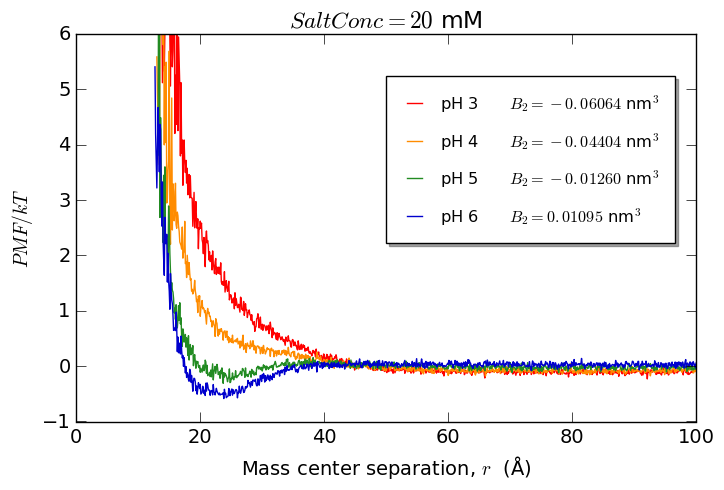

/Users/michael/Desktop/project-work-MarcoPolimeni-master/Plectasin
/Users/michael/Desktop/project-work-MarcoPolimeni-master/Plectasin/0.06
/Users/michael/Desktop/project-work-MarcoPolimeni-master/Plectasin/0.06/3
/Users/michael/Desktop/project-work-MarcoPolimeni-master/Plectasin/0.06
/Users/michael/Desktop/project-work-MarcoPolimeni-master/Plectasin/0.06/4
/Users/michael/Desktop/project-work-MarcoPolimeni-master/Plectasin/0.06
/Users/michael/Desktop/project-work-MarcoPolimeni-master/Plectasin/0.06/5
/Users/michael/Desktop/project-work-MarcoPolimeni-master/Plectasin/0.06
/Users/michael/Desktop/project-work-MarcoPolimeni-master/Plectasin/0.06/6
/Users/michael/Desktop/project-work-MarcoPolimeni-master/Plectasin/0.06


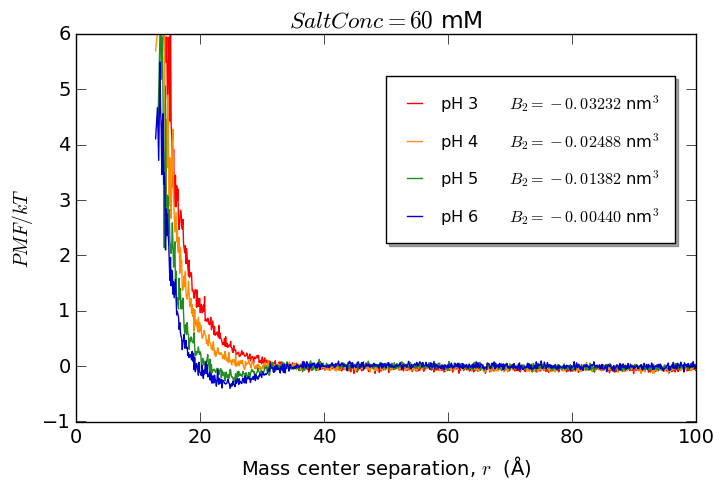

/Users/michael/Desktop/project-work-MarcoPolimeni-master/Plectasin
/Users/michael/Desktop/project-work-MarcoPolimeni-master


In [79]:
%cd $workdir/
    
#Dictionary

proteins = {
    'Plectasin': {
        'xyzfile':'../../../chain0.aam',
        'conc': [0.02,0.06], 'pH': [3,4,5,6]
    }
}

plt.rcParams.update({'font.size':14,'legend.frameon':True,'figure.figsize':[8,5],
                    'xtick.major.size':7,'ytick.major.size':7,
                    'legend.labelspacing':1})


B22=[]
for name, prop in proteins.items():
    %cd $name/
    for conc in prop['conc']:
        %cd $conc
        for pH,c in zip(prop['pH'],['r','darkorange','forestgreen','mediumblue']):
            %cd $pH
            x,y = np.loadtxt('rdf.dat',unpack=True)
            pmf=-np.log(y/y[:-100].mean())
            Mw=4400
            B2=-2*np.pi*np.trapz(np.expm1(-pmf)*x**2, x)*6.022e23*1e-24/Mw/Mw
            B22.append(B2)
            #plt.plot(x,pmf , '-', color=c,  label='pH '+str(pH), lw=2)
            #plt.plot(x, pmf, '-', color=c,  label='pH '+str(pH))
            plt.plot(x, pmf, '-', color=c,  label='pH '+str(pH)+'      $B_2={:1.5f}$'.format(B2)+' nm$^{3}$')
            
            plt.xlabel('Mass center separation, $r$  (Å)')
            plt.ylabel('$PMF/kT$')
            %cd ../
            
        plt.title('$Salt Conc={:1.0f}$'.format(conc*1e3)+' mM')
        plt.legend(loc=(0.5,0.46),ncol=1,shadow=True,borderpad=1,handlelength=1.5, fontsize='small')
        #plt.xlim(0,25)
        #plt.ylim(-2,9)
        plt.axis([0,100, -1, 6])#Range del plot
        #plt.plot([0,199],[0,4],'k--', lw=2.5)
        #print(workdir+'/MC/'+name+'/'+str(conc)+'/gofr.pdf')
        #plt.savefig(workdir+'/MC/'+name+'/'+str(conc)+'/pmf.pdf')
        plt.show()
              
        
        %cd ../
    %cd ../
    